In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import os

In [2]:
# download data
url = 'https://gitlab.com/yuxuan.chen/'\
    'storage/-/raw/master/DL-2020/week2/'\
    'prediction-challenge-01-data.npz'
!wget -nc $url

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)
print(test_x.shape, test_x.dtype)

File 'prediction-challenge-01-data.npz' already there; not retrieving.

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


In [3]:
# split the data into train and valid set: 16000 vs. 4000
train_size = 18000
train_x, val_x = data_x[:train_size, ], data_x[train_size:, ]
train_y, val_y = data_y[:train_size, ], data_y[train_size:, ]

In [4]:
# hyper-parameters
num_channels = [1, 16, 32]
num_classes = 10
num_epochs = 30
batch_size = 256
learning_rate = 0.002
weight_decay = 0.02

# set device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [5]:
 # create datasloader
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_loader = train_loader.shuffle(
    buffer_size=train_x.shape[0], 
    reshuffle_each_iteration=True
).batch(batch_size)

In [6]:
# build CNN of 2 conv-layers
class ConvNet(keras.Model):
    def __init__(self, output_size, num_channels):
        super(ConvNet, self).__init__()
        self.conv1 = keras.Sequential([
            layers.Conv2D(filters=num_channels[1], 
                          kernel_size=5, 
                          strides=1, 
                          padding='same',
                          data_format='channels_first'),
            layers.BatchNormalization(),
            layers.Activation('relu'), 
            layers.MaxPool2D(pool_size=2, strides=2)
        ])

        self.conv2 = keras.Sequential([
            layers.Conv2D(filters=num_channels[2], 
                          kernel_size=5, 
                          strides=1, 
                          padding='same',
                          data_format='channels_first'),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            layers.MaxPool2D(pool_size=2, strides=2)
        ])

        self.flatten = layers.Flatten()
        self.fc = layers.Dense(output_size)

    # forward pass
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

In [7]:
# compute loss for a batch
def cross_entropy_loss(outputs, labels):
    labels = tf.cast(labels, tf.int64)
    # prediction loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=outputs)
    return tf.reduce_mean(loss)


def accuracy(outputs, labels):
    hit = tf.equal(tf.argmax(outputs, 1), 
                   tf.cast(labels, tf.int64))
    return tf.reduce_mean(tf.cast(hit, tf.float32), axis=-1)

In [8]:
# set model and optimizer
model = ConvNet(output_size=num_classes,
                num_channels=num_channels)
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [9]:
# train the model
best_val_acc = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.numpy(), labels.numpy()

        with tf.GradientTape() as g:
            # forward pass
            outputs = model(images, training=True)
            loss =  cross_entropy_loss(outputs, labels)
            # regularization loss
            l2_loss = weight_decay * tf.add_n(
                [tf.nn.l2_loss(v) for v in model.trainable_variables])
            loss += l2_loss
            train_acc = accuracy(outputs, labels)
        
        # backward pass
        grad = g.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(
            zip(grad, model.trainable_variables))

    # report training loss and accuracy for the last batch 
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
        epoch + 1, num_epochs, loss.numpy()))
    print('Training Accuracy: {:.3f}%'.format(100 * train_acc))

    # validate after each epoch
    images, labels = val_x, val_y
    outputs = model(images, training=False)
    val_acc = accuracy(outputs, labels)
    print('Validation Accuracy: {:.3f}%'.format(100 * val_acc))
    print('=' * 50)

    # save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        if best_val_acc > 0.95:
            model.save_weights('./saved_model.ckpt', overwrite=True)

print('Best Valid Accuracy: {:.3f}%'.format(100 * best_val_acc))

Epoch [1/30], Training Loss: 1.0654
Training Accuracy: 92.500%
Validation Accuracy: 93.700%
Epoch [2/30], Training Loss: 0.6981
Training Accuracy: 98.750%
Validation Accuracy: 95.650%
Epoch [3/30], Training Loss: 0.5457
Training Accuracy: 98.750%
Validation Accuracy: 97.000%
Epoch [4/30], Training Loss: 0.4741
Training Accuracy: 97.500%
Validation Accuracy: 97.350%
Epoch [5/30], Training Loss: 0.3709
Training Accuracy: 98.750%
Validation Accuracy: 97.150%
Epoch [6/30], Training Loss: 0.3790
Training Accuracy: 96.250%
Validation Accuracy: 97.700%
Epoch [7/30], Training Loss: 0.2620
Training Accuracy: 97.500%
Validation Accuracy: 98.050%
Epoch [8/30], Training Loss: 0.3080
Training Accuracy: 96.250%
Validation Accuracy: 98.800%
Epoch [9/30], Training Loss: 0.2434
Training Accuracy: 96.250%
Validation Accuracy: 98.450%
Epoch [10/30], Training Loss: 0.2180
Training Accuracy: 98.750%
Validation Accuracy: 98.250%
Epoch [11/30], Training Loss: 0.2028
Training Accuracy: 98.750%
Validation Accu

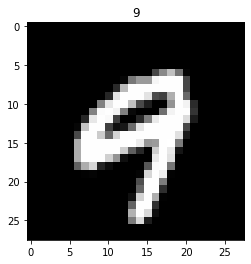

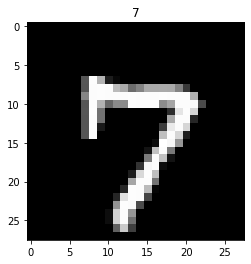

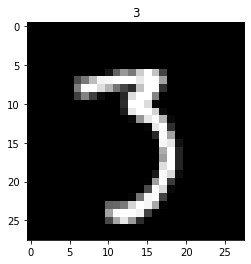

In [10]:
 # load the saved model
saved_model = ConvNet(num_classes, num_channels)
saved_model.load_weights('./saved_model.ckpt')

# predict on test set with the saved model
outputs = saved_model(test_x, training=False)
test_pred = tf.argmax(outputs, 1).numpy()

# show some answers
for i in range(3):
    plt.imshow(test_x[i].reshape(28, 28), cmap='gray')
    plt.title(test_pred[i])
    plt.show()